<a href="https://colab.research.google.com/github/michaelajao/topic-modelling-with-LDA/blob/master/covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#load library
import os
import pandas as pd
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import LsiModel
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import datetime
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# 1. Wordcloud of Top N words in each topic
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [2]:
meta = pd.read_csv("/content/drive/My Drive/covid-19 dataset/metadata.csv")
print(meta.shape)

(215527, 19)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
### first filter by meta file. select only papers after 2020
meta["publish_time"] = pd.to_datetime(meta["publish_time"])
meta["publish_year"] = (pd.DatetimeIndex(meta['publish_time']).year)
meta["publish_month"] = (pd.DatetimeIndex(meta['publish_time']).month)
meta = meta[meta["publish_year"] == 2020]
print(meta.shape[0], " papers are available after 2020 Jan 1.")

125869  papers are available after 2020 Jan 1.


In [4]:
#count how many has abstract
count = 0
index = []
for i in range(len(meta)):
    #print(i)
    if type(meta.iloc[i, 8])== float:
        count += 1
    else:
        index.append(i)

print(len(index), " papers have abstract available.")

76793  papers have abstract available.


In [5]:
##extract the abstract to pandas 
documents = meta.iloc[index, 8]
documents=documents.reset_index()
documents.drop("index", inplace = True, axis = 1)

##create pandas data frame with all abstracts, use as input corpus
documents["index"] = documents.index.values
#docs['abstract'] = docs['abstract'].str.lower()
documents.head(5)

,abstract,index
0,BACKGROUND: Dexmedetomidine has been reported ...,0
1,BACKGROUND: Global end-diastolic volume (GEDV)...,1
2,BACKGROUND: Human metapneumovirus (HMPV) is an...,2
3,BACKGROUND: Antimicrobial resistance (AMR) com...,3
4,Glycoconjugate vaccines based on bacterial cap...,4


In [6]:
stopwords = stopwords.words('english')

# function to tag first charater lemmatize accepts
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)



# Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item
lem = WordNetLemmatizer()

# this function loops through the words by properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word
def stop_lemmatize(doc):
    tokens = nltk.word_tokenize(doc)
    tmp = ""
    for w in tokens:
        if w not in stopwords:
            tmp += lem.lemmatize(w, get_wordnet_pos(w)) + " "
    return tmp


# Tokenize and lemmatize
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(stop_lemmatize(token))
    return result

In [7]:
# use example to check the preprocessing step

document_num = 1000  ##randomly pick one abstract
doc_sample = documents[documents["index"] == document_num].values[0][0]

print("Original document: ")
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print("\n\nTokenized and lemmatized document: ")
print(preprocess(doc_sample))

Original document: 
['OBJECTIVES:', 'To', 'describe', 'experience', 'with', 'airway', 'pressure', 'release', 'ventilation', '(APRV)', 'in', 'children', 'with', 'severe', 'acute', 'respiratory', 'distress', 'syndrome', '(ARDS)', 'refractory', 'to', 'conventional', 'low', 'tidal', 'volume', 'ventilation.', 'METHODS:', 'This', 'retrospective', 'observational', 'study', 'was', 'performed', 'in', 'an', '11-bed,', 'level', '3', 'pediatric', 'intensive', 'care', 'unit.', 'Evaluation', 'was', 'made', 'of', '30', 'pediatric', 'patients', 'receiving', 'airway', 'pressure', 'release', 'ventilation', 'as', 'rescue', 'therapy', 'for', 'severe', 'ARDS.', 'RESULTS:', 'Patients', 'were', 'switched', 'to', 'APRV', 'on', 'an', 'average', '3.2', '±', '2.6', 'd', 'following', 'intubation.', 'When', 'changed', 'from', 'conventional', 'mechanical', 'ventilation', '(CMV)', 'to', 'APRV,', 'there', 'was', 'an', 'expected', 'increase', 'in', 'the', 'SpO(2)/FiO(2)', 'ratio', '(165.1', '±', '13.6', 'vs.', '131.7'

In [8]:
processed_docs = documents['abstract'].map(preprocess)
processed_docs[:5]


0    [background , dexmedetomidine , report , impro...
1    [background , global , diastolic , volume , ge...
2    [background , human , metapneumovirus , hmpv ,...
3    [background , antimicrobial , resistance , com...
4    [glycoconjugate , vaccine , base , bacterial ,...
Name: abstract, dtype: object

In [9]:
##create dictionary based on the preprocessed_documents
dictionary = gensim.corpora.Dictionary(processed_docs)

##check the dictionary
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 5:
        break

0 acute 
1 adult 
2 analysis 
3 apache 
4 assessment 
5 associate 


In [10]:
## remove extreme words (very common and very rare)
dictionary.filter_extremes(no_below=15, no_above=0.1)

##create bag-of-word model for each documents
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [11]:
## check the bow_corpus
bow_doc_1000 = bow_corpus[document_num]

for i in range(len(bow_doc_1000)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_1000[i][0], 
                                                     dictionary[bow_doc_1000[i][0]], 
                                                     bow_doc_1000[i][1]))

Word 18 ("evaluation ") appears 1 time.
Word 29 ("intensive ") appears 1 time.
Word 33 ("low ") appears 1 time.
Word 34 ("mean ") appears 2 time.
Word 56 ("significantly ") appears 2 time.
Word 63 ("unit ") appears 1 time.
Word 132 ("volume ") appears 1 time.
Word 140 ("child ") appears 1 time.
Word 257 ("advantage ") appears 1 time.
Word 314 ("mechanical ") appears 2 time.
Word 322 ("observational ") appears 1 time.
Word 332 ("receive ") appears 1 time.
Word 344 ("therapy ") appears 1 time.
Word 345 ("ventilation ") appears 6 time.
Word 558 ("retrospective ") appears 1 time.
Word 584 ("prior ") appears 1 time.
Word 694 ("ratio ") appears 1 time.
Word 771 ("airway ") appears 3 time.
Word 778 ("ards ") appears 3 time.
Word 786 ("distress ") appears 1 time.
Word 790 ("expect ") appears 1 time.
Word 800 ("inspiratory ") appears 1 time.
Word 805 ("mode ") appears 1 time.
Word 814 ("pressure ") appears 4 time.
Word 820 ("release ") appears 2 time.
Word 828 ("tidal ") appears 1 time.
Word 89

In [12]:
#create tf-idf from bow_corpus
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

#preview the corpus_tfidf
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.03403260458266885),
 (1, 0.16361408568404048),
 (2, 0.03535088978060752),
 (3, 0.1310371842817303),
 (4, 0.03677461984120049),
 (5, 0.05726543197196434),
 (6, 0.04146750820251161),
 (7, 0.0415944984057982),
 (8, 0.049816193506380356),
 (9, 0.06231823000457256),
 (10, 0.041150543226290276),
 (11, 0.052571649814354984),
 (12, 0.05984222181568287),
 (13, 0.030023036442793027),
 (14, 0.12296306933965084),
 (15, 0.7433202464006221),
 (16, 0.030180843434901287),
 (17, 0.04489323266087939),
 (18, 0.0358395729519607),
 (19, 0.04320084991503403),
 (20, 0.033814410566371786),
 (21, 0.06509225604409087),
 (22, 0.0358920769799695),
 (23, 0.032208000680319995),
 (24, 0.06310475117148273),
 (25, 0.08352130932491367),
 (26, 0.03999982492839238),
 (27, 0.03532416387190441),
 (28, 0.0490396422246034),
 (29, 0.033115125787726615),
 (30, 0.05597535831366452),
 (31, 0.033123365219561204),
 (32, 0.05515824229751249),
 (33, 0.08764991721250144),
 (34, 0.030219046577205436),
 (35, 0.06896773774143643)

In [13]:
now = datetime.datetime.now()
print ("start model building at ",now.strftime("%Y-%m-%d %H:%M:%S"))
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics=5, 
                                       id2word = dictionary, 
                                       passes = 50, 
                                       workers=10) 

now = datetime.datetime.now()
print ('Model training finished at ',now.strftime("%Y-%m-%d %H:%M:%S"))

start model building at  2020-08-23 17:27:36
Model training finished at  2020-08-23 17:59:47


In [14]:
##print out the key words of five topics
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))
    print("\n")

Topic: 0 
Words: 0.014*"drug " + 0.012*"protein " + 0.008*"vaccine " + 0.007*"immune " + 0.007*"target " + 0.006*"receptor " + 0.006*"therapeutic " + 0.006*"host " + 0.005*"gene " + 0.005*"expression "


Topic: 1 
Words: 0.008*"healthcare " + 0.007*"practice " + 0.006*"service " + 0.005*"surgery " + 0.005*"emergency " + 0.005*"worker " + 0.005*"cancer " + 0.005*"mental " + 0.005*"face " + 0.005*"survey "


Topic: 2 
Words: 0.008*"day " + 0.007*"pneumonia " + 0.007*"diagnosis " + 0.006*"sample " + 0.006*"lung " + 0.006*"laboratory " + 0.005*"admission " + 0.005*"blood " + 0.005*"significantly " + 0.005*"chest "


Topic: 3 
Words: 0.006*"paper " + 0.005*"information " + 0.005*"propose " + 0.005*"learn " + 0.004*"network " + 0.004*"tool " + 0.004*"system " + 0.004*"process " + 0.003*"development " + 0.003*"work "


Topic: 4 
Words: 0.010*"estimate " + 0.008*"contact " + 0.007*"state " + 0.007*"period " + 0.007*"lockdown " + 0.006*"wuhan " + 0.006*"region " + 0.006*"city " + 0.006*"distanc

In [15]:
now = datetime.datetime.now()
print ("start model building at ",now.strftime("%Y-%m-%d %H:%M:%S"))

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, 
                                             num_topics=5, 
                                             id2word = dictionary, 
                                             passes = 50, 
                                             workers=10)
now = datetime.datetime.now()
print ('Model training finished at ',now.strftime("%Y-%m-%d %H:%M:%S"))

start model building at  2020-08-23 17:59:47
Model training finished at  2020-08-23 18:46:27


In [16]:
## check the key words of five topics
for idx, topic in lda_model_tfidf.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))
    print("\n")

Topic: 0 Word: 0.006*"estimate " + 0.004*"lockdown " + 0.003*"distance " + 0.003*"woman " + 0.003*"state " + 0.003*"city " + 0.003*"pregnant " + 0.003*"region " + 0.003*"italy " + 0.003*"policy "


Topic: 1 Word: 0.003*"healthcare " + 0.003*"practice " + 0.003*"service " + 0.002*"mental " + 0.002*"face " + 0.002*"crisis " + 0.002*"work " + 0.002*"emergency " + 0.002*"resource " + 0.002*"community "


Topic: 2 Word: 0.004*"therapy " + 0.004*"diabetes " + 0.004*"complication " + 0.003*"admission " + 0.003*"injury " + 0.003*"trial " + 0.003*"liver " + 0.003*"cancer " + 0.003*"cardiovascular " + 0.003*"ventilation "


Topic: 3 Word: 0.007*"sample " + 0.006*"chest " + 0.006*"assay " + 0.006*"detection " + 0.006*"image " + 0.006*"diagnosis " + 0.005*"pneumonia " + 0.005*"swab " + 0.005*"asymptomatic " + 0.005*"child "


Topic: 4 Word: 0.006*"drug " + 0.006*"protein " + 0.005*"vaccine " + 0.004*"immune " + 0.004*"host " + 0.004*"receptor " + 0.004*"target " + 0.003*"antiviral " + 0.003*"expre

In [19]:
now = datetime.datetime.now()
print ("start model building at ",now.strftime("%Y-%m-%d %H:%M:%S"))

lsi_model_tfidf = gensim.models.LsiModel(corpus_tfidf, 
                                             num_topics=5, 
                                             id2word = dictionary,
                                         )
now = datetime.datetime.now()
print ('Model training finished at ',now.strftime("%Y-%m-%d %H:%M:%S"))

start model building at  2020-08-23 18:51:04
Model training finished at  2020-08-23 18:51:33


In [20]:
## check the key words of five topics
for idx, topic in lsi_model_tfidf.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))
    print("\n")

Topic: 0 Word: 0.104*"drug " + 0.084*"day " + 0.081*"pneumonia " + 0.080*"child " + 0.078*"healthcare " + 0.076*"protein " + 0.073*"vaccine " + 0.072*"cancer " + 0.071*"therapy " + 0.071*"wuhan "


Topic: 1 Word: -0.234*"protein " + -0.234*"drug " + -0.142*"antibody " + -0.141*"receptor " + -0.135*"vaccine " + -0.130*"binding " + -0.122*"immune " + -0.117*"target " + -0.116*"host " + 0.116*"healthcare "


Topic: 2 Word: -0.190*"drug " + 0.157*"chest " + 0.152*"day " + 0.152*"child " + 0.150*"pneumonia " + -0.138*"vaccine " + 0.129*"admission " + 0.125*"image " + 0.106*"laboratory " + -0.106*"protein "


Topic: 3 Word: 0.226*"cancer " + -0.193*"assay " + -0.181*"antibody " + -0.153*"sample " + -0.152*"detection " + 0.128*"therapy " + -0.128*"estimate " + 0.117*"cytokine " + 0.115*"injury " + 0.113*"drug "


Topic: 4 Word: -0.376*"cancer " + -0.195*"surgery " + -0.170*"image " + 0.161*"mental " + -0.157*"surgical " + 0.155*"anxiety " + 0.130*"lockdown " + -0.120*"assay " + 0.118*"psychol

In [21]:
documents_lda_topics = pd.DataFrame(columns = ["topic1", "topic2", "topic3", "topic4", "topic5"])
documents_lda_tfidf_topics = pd.DataFrame(columns = ["topic1", "topic2", "topic3", "topic4", "topic5"])
for i in range(len(bow_corpus)):
    if i % 500 ==0:
        print(i)
    documents_lda_topics.loc[i] = [0] * 5
    documents_lda_tfidf_topics.loc[i] = [0] * 5
    
    output = lda_model.get_document_topics(bow_corpus[i])
    for j in range(len(output)):
        a = output[j][0]
        b = output[j][1]
        documents_lda_topics.iloc[i,a] = b
    
    output_tfidf = lda_model_tfidf.get_document_topics(bow_corpus[i])
    for k in range(len(output_tfidf)):
        a = output_tfidf[k][0]
        b = output_tfidf[k][1]
        documents_lda_tfidf_topics.iloc[i, a] = b
        
print("Data processing finished")


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000
75500
76000
76500
Data processing finished


In [22]:
## pick the final topic for each abstract based on max-probability
for i in range(5):
    documents_lda_topics.iloc[:, i] = documents_lda_topics.iloc[:, i].astype('float64', copy=False)
    
documents_lda_topics["final_topic"] =documents_lda_topics.iloc[:, :10].idxmax(axis=1)

for i in range(5):
    documents_lda_tfidf_topics.iloc[:, i] = documents_lda_tfidf_topics.iloc[:, i].astype('float64', copy=False)

documents_lda_tfidf_topics["final_topic"] =documents_lda_tfidf_topics.iloc[:, :10].idxmax(axis=1)

In [23]:
##preview the dataframe for both models
print("LDA + bow_corpus: topic probability:")
documents_lda_topics.head(5)
print("LDA + TF-IDF_corpus: topic probability:")
documents_lda_tfidf_topics.head(5)

LDA + bow_corpus: topic probability:
LDA + TF-IDF_corpus: topic probability:


,topic1,topic2,topic3,topic4,topic5,final_topic
0,0.000000,0.000000,0.992394,0.000000,0.000000,topic3
1,0.128949,0.000000,0.865258,0.000000,0.000000,topic3
2,0.000000,0.000000,0.000000,0.323546,0.668969,topic5
3,0.140570,0.412857,0.101600,0.000000,0.343479,topic2
4,0.000000,0.000000,0.000000,0.000000,0.984186,topic5


In [38]:
def get_wordcloud(topic):

  cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

  cloud = WordCloud(stopwords=STOPWORDS,
                    background_color='white',
                    width=2500,
                    height=1800,
                    max_words=10,
                    colormap='tab10',
                    color_func=lambda *args, **kwargs: cols[i],
                    prefer_horizontal=1.0)

  topics = topic.show_topics(formatted=False)

  fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

  for i, ax in enumerate(axes.flatten()):
      fig.add_subplot(ax)
      topic_words = dict(topics[i][1])
      cloud.generate_from_frequencies(topic_words, max_font_size=300)
      plt.gca().imshow(cloud)
      plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
      plt.gca().axis('off')


  plt.subplots_adjust(wspace=0, hspace=0)
  plt.axis('off')
  plt.margins(x=0, y=0)
  plt.tight_layout()
  plt.show()


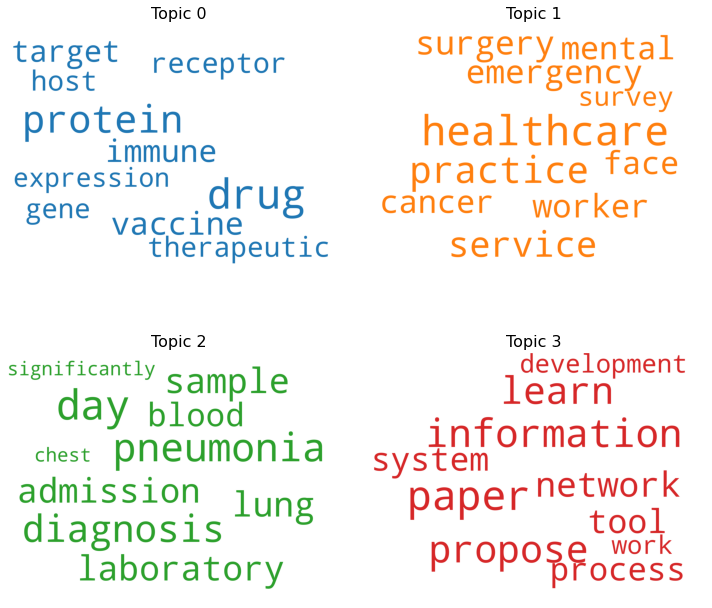

In [39]:
get_wordcloud(topic= lda_model)

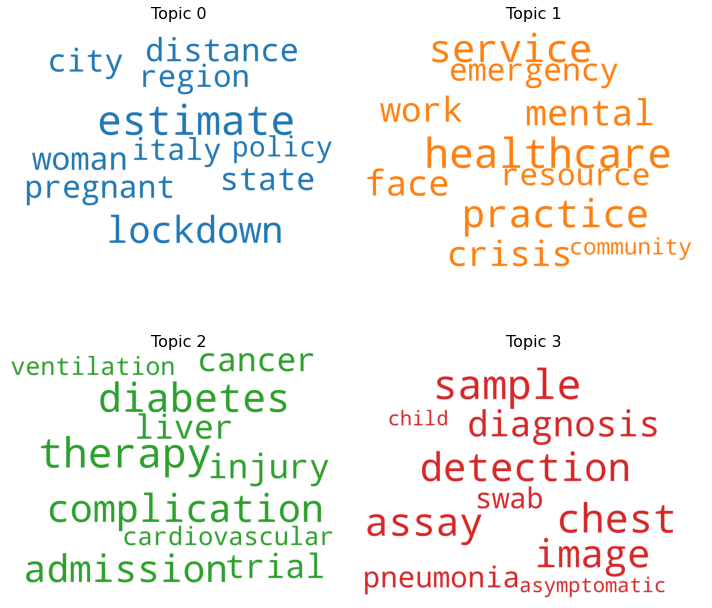

In [26]:
get_wordcloud(topic= lda_model_tfidf)

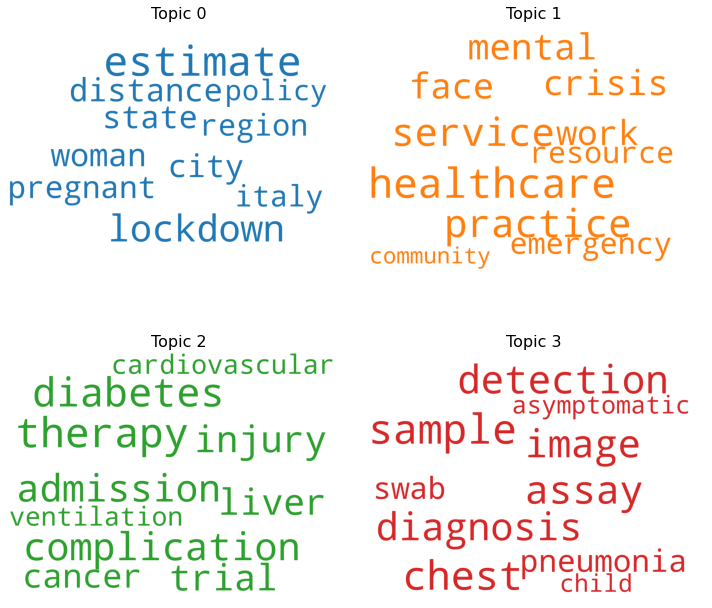

In [35]:
get_wordcloud(topic= lsi_model_tfidf)

In [27]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(documents_lda_tfidf_topics.iloc[:, :5])

In [28]:
## with 3 components, variance explained
pca.explained_variance_ratio_

array([0.38398292, 0.24383152, 0.22608589])

In [29]:
##create dataframe with projected vectors from PCA
pca_df = pd.DataFrame()
pca_df['pca-one'] = pca_result[:,0]
pca_df['pca-two'] = pca_result[:,1] 
pca_df["pca-three"] = pca_result[:, 2]
pca_df["topic"] = documents_lda_tfidf_topics.iloc[:, 5].replace({"topic1": "red", "topic2": "blue", "topic3": "green", "topic4": "yellow", "topic5": "black"})

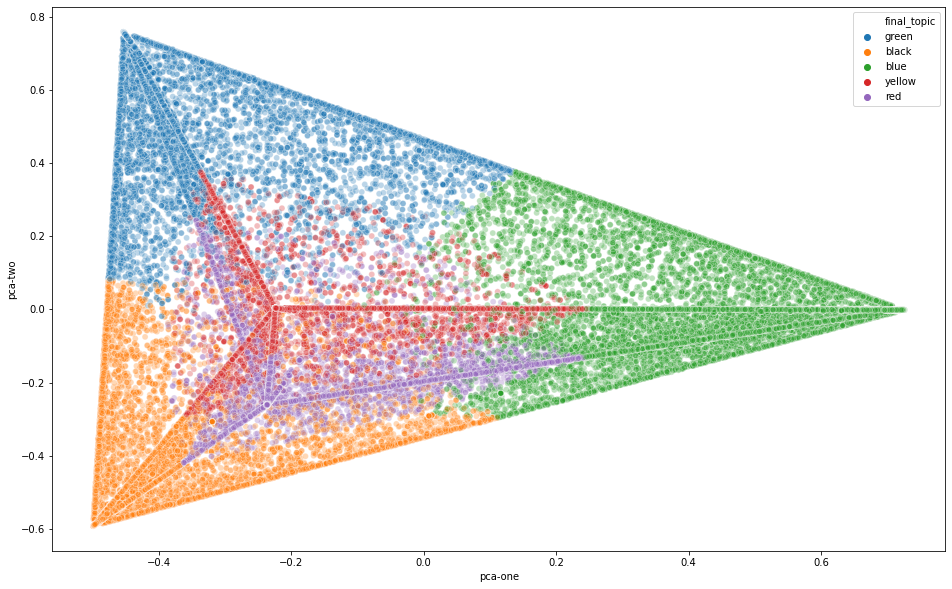

In [30]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue= documents_lda_tfidf_topics.iloc[:, 5].replace({"topic1": "red", "topic2": "blue", "topic3": "green", "topic4": "yellow", "topic5": "black"}),
    data=pca_df,
    legend="full",
    alpha=0.3)

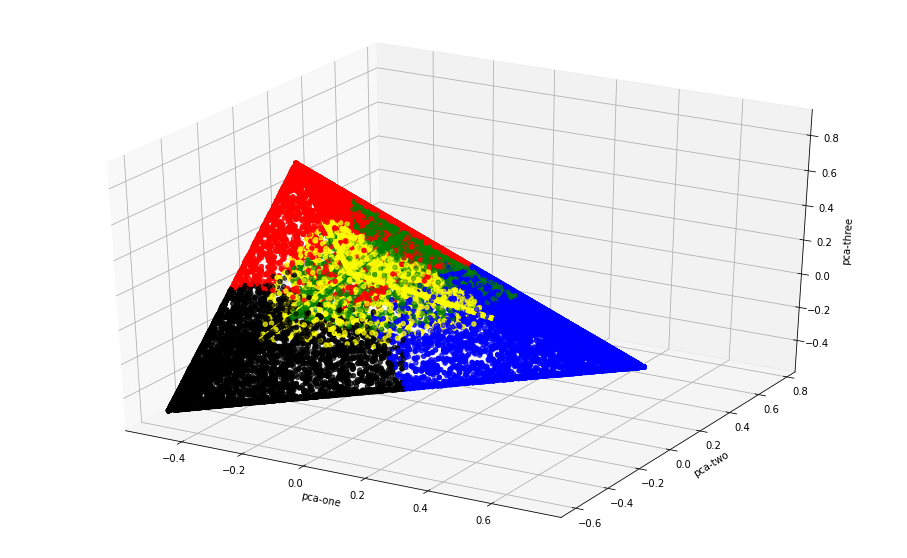

In [31]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_df["pca-one"], 
    ys=pca_df["pca-two"], 
    zs=pca_df["pca-three"], 
    cmap='tab10',
    c = documents_lda_tfidf_topics.iloc[:, 5].replace({"topic1": "red", "topic2": "blue", "topic3": "green", "topic4": "yellow", "topic5": "black"})
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [32]:
##first run TSNE
import time
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(documents_lda_tfidf_topics.iloc[:, :5])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 76793 samples in 2.409s...
[t-SNE] Computed neighbors for 76793 samples in 3.873s...
[t-SNE] Computed conditional probabilities for sample 1000 / 76793
[t-SNE] Computed conditional probabilities for sample 2000 / 76793
[t-SNE] Computed conditional probabilities for sample 3000 / 76793
[t-SNE] Computed conditional probabilities for sample 4000 / 76793
[t-SNE] Computed conditional probabilities for sample 5000 / 76793
[t-SNE] Computed conditional probabilities for sample 6000 / 76793
[t-SNE] Computed conditional probabilities for sample 7000 / 76793
[t-SNE] Computed conditional probabilities for sample 8000 / 76793
[t-SNE] Computed conditional probabilities for sample 9000 / 76793
[t-SNE] Computed conditional probabilities for sample 10000 / 76793
[t-SNE] Computed conditional probabilities for sample 11000 / 76793
[t-SNE] Computed conditional probabilities for sample 12000 / 76793
[t-SNE] Computed conditional probabilities for sa

In [33]:
##create dataframe with TSNE results
tsne_df = pd.DataFrame()
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]

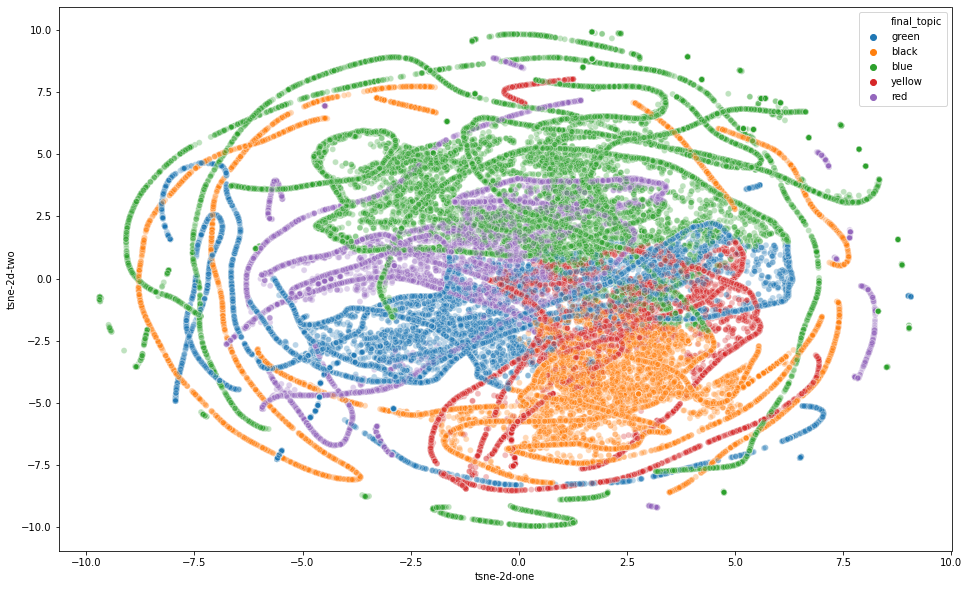

In [34]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=documents_lda_tfidf_topics.iloc[:, 5].replace({"topic1": "red", "topic2": "blue", "topic3": "green", "topic4": "yellow", "topic5": "black"}),
    #palette=sns.color_palette("hls", 10),
    data=tsne_df,
    legend="full",
    alpha=0.3)